In [1]:
!pip install pandas numpy matplotlib statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load the dataset
data = pd.read_csv('/content/headstart.csv')

print(data.columns)

Index(['oldcode', 'state', 'povrate60', 'mort_age59_related_postHS',
       'mort_age59_injury_postHS', 'mort_age59_all_postHS',
       'mort_age25plus_related_postHS', 'mort_age25plus_injuries_postHS',
       'mort_age59_related_preHS', 'mort_wh_age59_related_postHS',
       'mort_bl_age59_related_postHS', 'census1960_pop',
       'census1960_pctsch1417', 'census1960_pctsch534',
       'census1960_pctsch25plus', 'census1960_pop1417', 'census1960_pop534',
       'census1960_pop25plus', 'census1960_pcturban', 'census1960_pctblack',
       'census1990_pop', 'census1990_pop1824', 'census1990_pop2534',
       'census1990_pop3554', 'census1990_pop55plus', 'census1990_pcturban',
       'census1990_pctblack', 'census1990_percapinc'],
      dtype='object')


In [4]:
import pandas as pd
import statsmodels.formula.api as smf


# Load the dataset
df = pd.read_csv('/content/headstart.csv')

# Define the treatment variable based on the poverty rate cutoff
df['Nearest_neighbors'] = (df['povrate60'] >= 59.1984).astype(int)

# Reproduce Table II: Effects of Head Start on Mortality
# Define dependent variables for mortality rates
mort_vars = ['mort_age59_related_postHS', 'mort_age59_injury_postHS', 'mort_age59_all_postHS']

# Run regressions for each mortality rate variable
table_2_results = []
for mort_var in mort_vars:
    model = smf.ols(f"{mort_var} ~ povrate60 + Nearest_neighbors + povrate60 * Nearest_neighbors", data=df)
    results = model.fit(cov_type='HC1')
    table_2_results.append({
        'Dependent Variable': mort_var,
        'Treatment Effect (Nearest_neighbors)': results.params['Nearest_neighbors'],
        'p-value': results.pvalues['Nearest_neighbors']
    })

# Convert results to a DataFrame
table_2_df = pd.DataFrame(table_2_results)

# Reproduce Table IV: Effects of Head Start on High School Completion
# Define dependent variables for high school completion rates
hs_completion_vars = ['census1990_pop1824', 'census1990_pop2534']

# Run regressions for each high school completion rate variable
table_4_results = []
for hs_var in hs_completion_vars:
    model = smf.ols(f"{hs_var} ~ povrate60 + Nearest_neighbors + povrate60 * Nearest_neighbors", data=df)
    results = model.fit(cov_type='HC1')
    table_4_results.append({
        'Dependent Variable': hs_var,
        'Treatment Effect (Nearest_neighbors)': results.params['Nearest_neighbors'],
        'p-value': results.pvalues['Nearest_neighbors']
    })

# Convert results to a DataFrame
table_4_df = pd.DataFrame(table_4_results)

# Print the results
print("Table II: Effects of Head Start on Mortality")
print(table_2_df)
print("\nTable IV: Effects of Head Start on High School Completion")
print(table_4_df)

Table II: Effects of Head Start on Mortality
          Dependent Variable  Treatment Effect (Nearest_neighbors)   p-value
0  mort_age59_related_postHS                             -2.095183  0.459194
1   mort_age59_injury_postHS                             -6.209877  0.680211
2      mort_age59_all_postHS                            -13.025781  0.503913

Table IV: Effects of Head Start on High School Completion
   Dependent Variable  Treatment Effect (Nearest_neighbors)   p-value
0  census1990_pop1824                             -0.004874  0.740117
1  census1990_pop2534                             -0.018297  0.177830


In [7]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols

# Load the dataset
df = pd.read_csv('/content/headstart.csv')

# Define the cutoff for the Head Start assignment
cutoff = 59.1984  # Replace with actual cutoff if different

# Create the Head Start assignment indicator
df['HeadStart'] = (df['povrate60'] >= cutoff).astype(int)

# Choose an outcome variable
outcome_variable = 'mort_age59_related_postHS'  # Replace with the actual outcome variable of interest

# Filter out 0 and NA values from the outcome variable
df = df[df[outcome_variable] != 0]
df = df.dropna(subset=[outcome_variable])

# Fit the regression discontinuity model
# For a linear model:
model_linear = ols(f'{outcome_variable} ~ HeadStart + povrate60', data=df).fit()

# For a model with a higher-order polynomial, add terms like I(povrate60 ** 2), I(povrate60 ** 3), etc.
model_polynomial = ols(f'{outcome_variable} ~ HeadStart + povrate60 + np.power(povrate60, 2)', data=df).fit()

# View the summary of the linear model
print(model_linear.summary())

# View the summary of the polynomial model
print(model_polynomial.summary())




                                OLS Regression Results                               
Dep. Variable:     mort_age59_related_postHS   R-squared:                       0.037
Model:                                   OLS   Adj. R-squared:                  0.035
Method:                        Least Squares   F-statistic:                     19.62
Date:                       Tue, 27 Feb 2024   Prob (F-statistic):           4.33e-09
Time:                               18:40:38   Log-Likelihood:                -3616.5
No. Observations:                       1037   AIC:                             7239.
Df Residuals:                           1034   BIC:                             7254.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

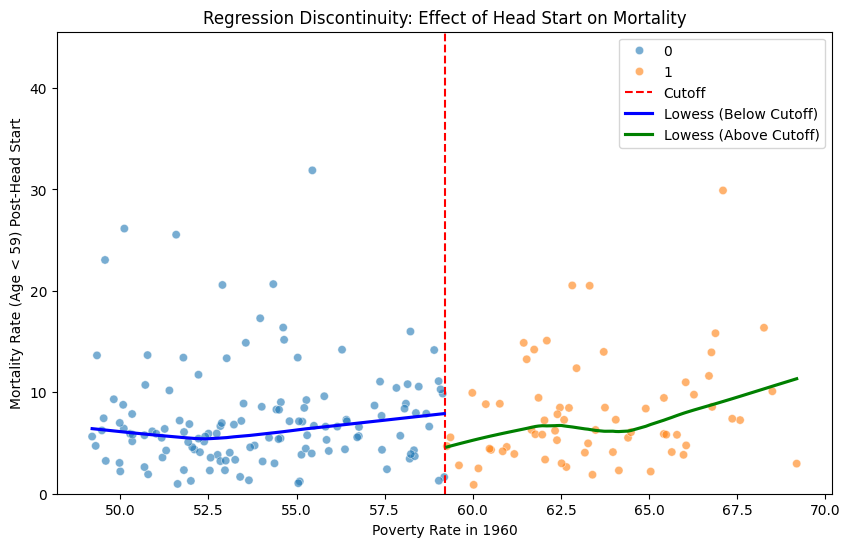

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the bandwidth for visualization
bandwidth = 10  # Adjust this value as needed

# Filter the data around the cutoff for visualization
df_filtered = df[(df['povrate60'] >= cutoff - bandwidth) & (df['povrate60'] <= cutoff + bandwidth)]

# Plot the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='povrate60', y=outcome_variable, hue='HeadStart', data=df_filtered, alpha=0.6)
plt.axvline(x=cutoff, color='red', linestyle='--', label='Cutoff')

# Add non-parametric lines
sns.regplot(x='povrate60', y=outcome_variable, data=df_filtered[df_filtered['HeadStart'] == 0], lowess=True, scatter=False, label='Lowess (Below Cutoff)', color='blue')
sns.regplot(x='povrate60', y=outcome_variable, data=df_filtered[df_filtered['HeadStart'] == 1], lowess=True, scatter=False, label='Lowess (Above Cutoff)', color='green')

plt.xlabel('Poverty Rate in 1960')
plt.ylabel('Mortality Rate (Age < 59) Post-Head Start')
plt.title('Regression Discontinuity: Effect of Head Start on Mortality')

# Adjust the y-axis range
plt.ylim(bottom=0, top=df_filtered[outcome_variable].max() * 0.7)  # Adjust the upper limit as needed

plt.legend()
plt.show()

